### Load the Dataframe from the file

In [226]:
import chart_studio
import os

client_id = os.environ["PLOTLY_NAME"]
client_secret = os.environ["PLOTLY_KEY"]

chart_studio.tools.set_credentials_file(
    username=client_id, 
    api_key=client_secret)
import chart_studio.plotly as py

In [1]:
import pickle

filename = 'flight_2019'

infile = open(filename,'rb')
flight_2019 = pickle.load(infile)
infile.close()

#### New dataframe with a smaller sample of 500,000 records

In [157]:
flight_sample = flight_2019.sample(n=1000000, random_state=1)

In [158]:
flight_sample.shape

(1000000, 38)

### Determine Flight Type counts for departure time of day

#### Create feature Flight Haul Type
Short-haul flight < 3 hours  
Medium-haul between 3-6 hours  
Long-haul flight > 6 hours  

In [18]:
print("Actual Elapsed Time datatype", flight_sample['actual_elapsed_time'].dtypes)
print(flight_sample['actual_elapsed_time'].isnull().values.any())
print("Flights with no elapsed time", flight_sample['actual_elapsed_time'].isna().sum())
print(flight_sample['crs_elapsed_time'].isna().sum())
print(flight_sample['air_time'].isna().sum())
print("Flights Cancelled", flight_sample[flight_sample['cancelled'] == 1]['cancelled'].sum())
print("Flights Diverted", flight_sample[flight_sample['diverted'] == 1]['diverted'].sum())

Actual Elapsed Time datatype float64
True
Flights with no elapsed time 21530
0
21530
Flights Cancelled 19025.0
Flights Diverted 2505.0


In [33]:

# 0 - SHORT HAUL
# 1 - MEDIUM HAUL
# 2 - LONG HAUL
flights_completed = flight_sample[(
    (flight_sample['cancelled'] == 0) & (flight_sample['diverted'] == 0)
)]

print(flights_completed['actual_elapsed_time'].isnull().values.any())

flight_sample['haul_type'] = flights_completed.apply(
    lambda x: 0 if x['actual_elapsed_time'] <= 180.0 else (2 if x['actual_elapsed_time'] >= 360.0 else 1), axis=1
)

False


In [34]:
flight_sample[['actual_elapsed_time','haul_type']].head()

,actual_elapsed_time,haul_type
5817519,149.0,0.0
3440584,63.0,0.0
2213756,205.0,1.0
4372882,231.0,1.0
2224046,222.0,1.0


#### Group data by hour of departure and haul type

In [44]:
from datetime import datetime
flight_sample['dep_hour_of_day'] = flight_sample[flight_sample['dep_time'].notna()].apply(
    lambda x: 0 if x['dep_time'] == 2400.0 else datetime.strptime(str(int(x['dep_time'])).zfill(4), '%H%M').time().hour, axis=1)
flight_sample['dep_hour_of_day'].head()

5817519    19.0
3440584    20.0
2213756    18.0
4372882     6.0
2224046    13.0
3190610    21.0
4376082    14.0
115103     18.0
1584068    19.0
4766272    11.0
4927957    16.0
2068764    13.0
42660      11.0
7690177     8.0
3640340    10.0
6254474     5.0
5402161    17.0
5077495    12.0
2569121    12.0
3692948    11.0
7621415    11.0
7619144    14.0
8089056    13.0
7732341     9.0
Name: dep_hour_of_day, dtype: float64

In [45]:
flight_sample['dep_hour_of_day'].describe()

count    981703.000000
mean         13.038528
std           5.057750
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          23.000000
Name: dep_hour_of_day, dtype: float64

In [55]:
haul_type_by_hour = flight_sample.groupby(
    ['dep_hour_of_day','haul_type']).agg(total_flights=('haul_type', 'count')).reset_index()
haul_type_by_hour.head()

,dep_hour_of_day,haul_type,total_flights
0,0.0,0.0,1868
1,0.0,1.0,2252
2,0.0,2.0,28
3,1.0,0.0,754
4,1.0,1.0,766


In [56]:
haul_type_by_hour.describe()

,dep_hour_of_day,haul_type,total_flights
count,72.000000,72.000000,72.000000
mean,11.500000,1.000000,13589.861111
std,6.970764,0.822226,18170.241985
min,0.000000,0.000000,1.000000
25%,5.750000,0.000000,646.750000
50%,11.500000,1.000000,4890.000000
75%,17.250000,2.000000,15149.250000
max,23.000000,2.000000,50341.000000


In [57]:
haul_type_by_hour[haul_type_by_hour['dep_hour_of_day'] == 23].head()

,dep_hour_of_day,haul_type,total_flights
69,23.0,0.0,5630
70,23.0,1.0,4588
71,23.0,2.0,84


#### Chart the aggregate dataframe as a bar graph

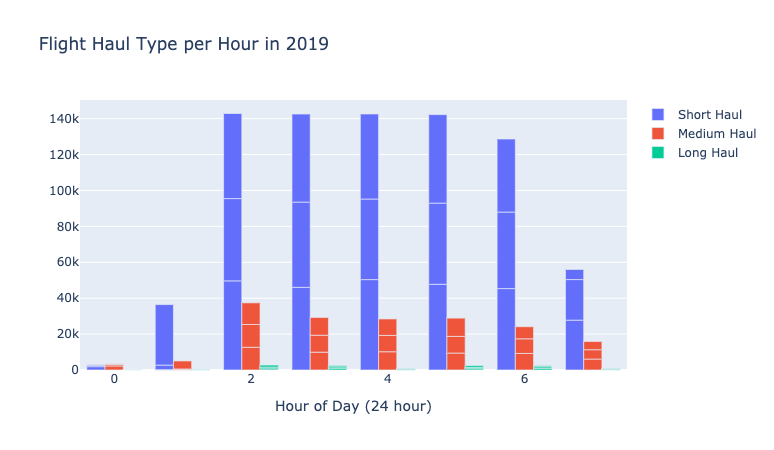

'https://plotly.com/~GailB-ca/30/'

In [228]:
import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Bar(name="Short Haul", 
                     x=haul_type_by_hour['dep_hour_of_day'], 
                     y=haul_type_by_hour[haul_type_by_hour['haul_type'] == 0.0]['total_flights']))
fig.add_trace(go.Bar(name="Medium Haul", 
                     x=haul_type_by_hour['dep_hour_of_day'], 
                     y=haul_type_by_hour[haul_type_by_hour['haul_type'] == 1.0]['total_flights']))
fig.add_trace(go.Bar(name="Long Haul", 
                     x=haul_type_by_hour['dep_hour_of_day'], 
                     y=haul_type_by_hour[haul_type_by_hour['haul_type'] == 2.0]['total_flights']))
fig.update_layout(
    title='Flight Haul Type per Hour in 2019',
    xaxis_title="Hour of Day (24 hour)")
fig.show()
py.plot(fig)


In [58]:
import matplotlib
import matplotlib.pyplot as plt

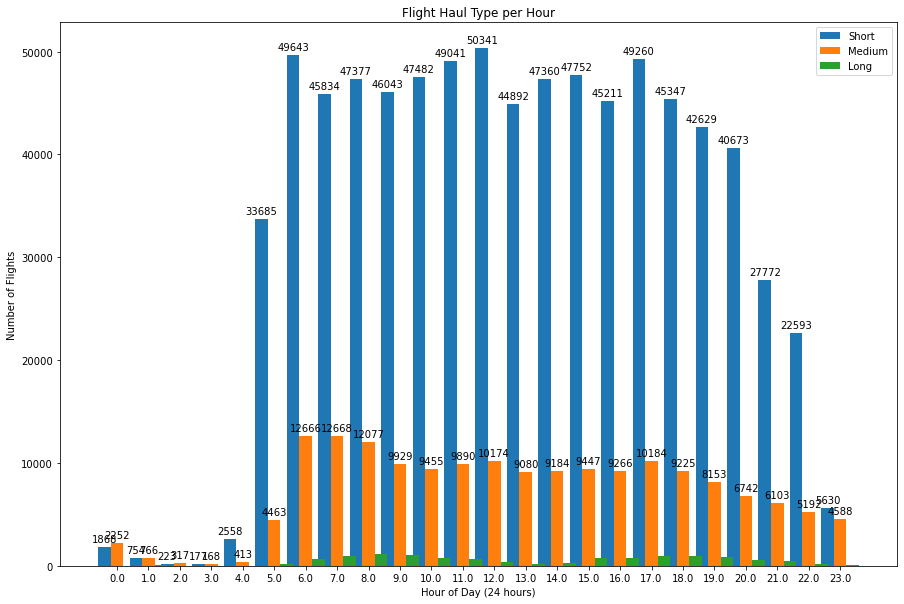

In [84]:
import numpy as np

labels = haul_type_by_hour.dep_hour_of_day.unique()
short_haul = haul_type_by_hour[haul_type_by_hour['haul_type'] == 0.0]['total_flights']
medium_haul = haul_type_by_hour[haul_type_by_hour['haul_type'] == 1.0]['total_flights']
long_haul = haul_type_by_hour[haul_type_by_hour['haul_type'] == 2.0]['total_flights']

x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x-0.4,short_haul, 0.4, label='Short')
rects2 = ax.bar(x, medium_haul, 0.4, label='Medium')
rects3 = ax.bar(x+0.4, long_haul, 0.4, label='Long')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Flights')
ax.set_xlabel('Hour of Day (24 hours)')
ax.set_title('Flight Haul Type per Hour')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

#fig.tight_layout()

plt.show()

#### Print the hour of day with the max flights of each haul type

In [94]:
idx_short = haul_type_by_hour[haul_type_by_hour['haul_type'] == 0]["total_flights"].idxmax()
row = haul_type_by_hour.iloc[idx_short]
print(row)

dep_hour_of_day       12.0
haul_type              0.0
total_flights      50341.0
Name: 36, dtype: float64


In [95]:
idx_medium = haul_type_by_hour[haul_type_by_hour['haul_type'] == 1]["total_flights"].idxmax()
row = haul_type_by_hour.iloc[idx_medium]
print(row)

dep_hour_of_day        7.0
haul_type              1.0
total_flights      12668.0
Name: 22, dtype: float64


In [96]:
idx_long = haul_type_by_hour[haul_type_by_hour['haul_type'] == 2]["total_flights"].idxmax()
row = haul_type_by_hour.iloc[idx_long]
print(row)

dep_hour_of_day       8.0
haul_type             2.0
total_flights      1138.0
Name: 26, dtype: float64


### Top 10 busiest airports. 
1. Does the biggest number of flights mean that biggest number of passengers go through the particular airport? 
2. How much traffic do these 10 airports cover?

#### Get top airport ids

In [100]:
flights_by_airport_count_2019 = flight_sample[['flights','origin_airport_id']].groupby('origin_airport_id').count().reset_index()
flights_by_airport_count_2019.head()

,origin_airport_id,flights
0,10135,863
1,10136,282
2,10140,3220
3,10141,83
4,10146,121


In [105]:
top_10_airports = flights_by_airport_count_2019.sort_values(by='flights', ascending=False).head(10)
top_10_airports

,origin_airport_id,flights
257,13930,49579
22,10397,49052
95,11298,38135
94,11292,35327
74,11057,31991
196,12892,30828
320,14747,23756
169,12266,22271
103,11433,21912
272,14107,21893


In [206]:
%run ./db_connection.ipynb

In [204]:
def get_airport_names(airport_ids):
    airport_names_query_2019 = """
       SELECT distinct
        origin,
        origin_airport_id
       FROM flights
       WHERE date_part('year', TO_DATE(fl_date,'YYYY-MM-DD')) = 2019
       and origin_airport_id in (
    """
    airport_names_query_2019 += ",".join([str(item) for item in airport_ids]) + ")"
    return execute_read_query(con, airport_names_query_2019)
    

In [207]:
top_10_flights_airports = get_airport_names(top_10_airports['origin_airport_id'].to_numpy())
top_10_airports_names_2019

,origin,origin_airport_id
0,ATL,10397
1,CLT,11057
2,DEN,11292
3,DFW,11298
4,DTW,11433
5,IAH,12266
6,LAX,12892
7,ORD,13930
8,PHX,14107
9,SEA,14747


In [224]:
top_10_airports_by_flights = top_10_airports.join(top_10_airports_names_2019.set_index('origin_airport_id'), on='origin_airport_id', rsuffix="dest")
top_10_airports_by_flights.head(10)

,origin_airport_id,flights,origin
257,13930,49579,ORD
22,10397,49052,ATL
95,11298,38135,DFW
94,11292,35327,DEN
74,11057,31991,CLT
196,12892,30828,LAX
320,14747,23756,SEA
169,12266,22271,IAH
103,11433,21912,DTW
272,14107,21893,PHX


ATL Georgia  
CLT Charlotte North Carolina  
DEN Denver Colorado  
DFW Dallas Fort Worth Texas  
DTW Detroit Michigan  
IAH Houston Texas  
LAX Los Angelos California  
ORD Chicago Illanois  
PHX Phoenix Arizona  
SEA Seattle Washington  

#### Get top airports for passenger totals

In [225]:
passenger_totals_query_2019 = """
   SELECT origin_airport_id,
    sum(passengers) as total_passengers
   FROM passengers   
   WHERE year = 2019  
   group by origin_airport_id
"""
passenger_totals_2019 = execute_read_query(con, passenger_totals_query_2019)
passenger_totals_2019.head(10)

,origin_airport_id,total_passengers
0,10005,25.0
1,10006,3.0
2,10009,16.0
3,10010,14.0
4,10011,18201.0
5,10014,2.0
6,10016,24.0
7,10017,0.0
8,10033,0.0
9,10039,15.0


In [210]:
top_10_passenger_airports = passenger_totals_2019.sort_values(by='total_passengers', ascending=False).head(10)
top_10_passenger_airports

,origin_airport_id,total_passengers
104,10397,53862700.0
833,12892,43362936.0
1118,13930,41009603.0
371,11298,35873581.0
369,11292,33891355.0
725,12478,31127957.0
1352,14771,27872098.0
1344,14747,24994731.0
926,13204,24788798.0
831,12889,24786545.0


In [211]:
print(top_10_passenger_airports['origin_airport_id'].to_numpy())

[10397 12892 13930 11298 11292 12478 14771 14747 13204 12889]


In [212]:
top_10_airports_names_passengers_2019 = get_airport_names(top_10_passenger_airports['origin_airport_id'].to_numpy())
top_10_airports_names_passengers_2019

,origin,origin_airport_id
0,ATL,10397
1,DEN,11292
2,DFW,11298
3,JFK,12478
4,LAS,12889
5,LAX,12892
6,MCO,13204
7,ORD,13930
8,SEA,14747
9,SFO,14771


In [213]:
top_10_airports_by_passengers = top_10_passenger_airports.join(top_10_airports_names_passengers_2019.set_index('origin_airport_id'), on='origin_airport_id', rsuffix="dest")
top_10_airports_by_passengers.head(10)

,origin_airport_id,total_passengers,origin
104,10397,53862700.0,ATL
833,12892,43362936.0,LAX
1118,13930,41009603.0,ORD
371,11298,35873581.0,DFW
369,11292,33891355.0,DEN
725,12478,31127957.0,JFK
1352,14771,27872098.0,SFO
1344,14747,24994731.0,SEA
926,13204,24788798.0,MCO
831,12889,24786545.0,LAS


#### Plot the busiest airports as bar charts

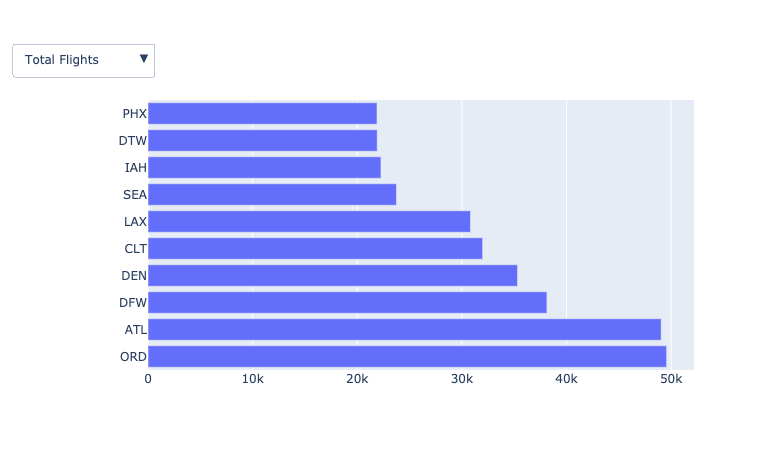

'https://plotly.com/~GailB-ca/32/'

In [229]:
fig = go.Figure()
fig.add_trace(go.Bar(
            x=top_10_airports_by_flights['flights'],
            y=top_10_airports_by_flights['origin'],
            orientation='h'))
buttons=list([dict(args=[{'x':[top_10_airports_by_flights['flights']],
                         'y':[top_10_airports_by_flights['origin']]}, [0]],                   
                   label="Total Flights",
                   method="restyle"
                ),
                dict(args=[{'x':[top_10_airports_by_passengers['total_passengers']],
                           'y': [top_10_airports_by_passengers['origin']]}, [0]],                 
                   label="Total Passengers",
                   method="restyle"
                )
            ])
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=-0.25,
            xanchor="left",
            y=1.25,
            yanchor="top"
        )
    ]
)

fig.show()
py.plot(fig)

Passenger counts not directly correlate with flight count at the top 10 busiest airports

### Delays and Fuel Consumption per Passenger

#### Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)

In [159]:
flight_sample['total_delay'] = flight_sample.apply(
    lambda x: ((x['dep_delay'] + x['arr_delay'] +
                 x['carrier_delay'] +
                 x['weather_delay'] + x['nas_delay'] + x['security_delay'] +
                 x['late_aircraft_delay']
              )),  axis=1)

flight_sample.shape

(1000000, 39)

In [162]:
flight_delays_per_month_by_carrier = flight_sample.groupby([
    'month','op_unique_carrier']).agg(avg=('total_delay', 'median')).reset_index()
flight_delays_per_month_by_carrier

,month,op_unique_carrier,avg
0,1.0,9E,131.5
1,1.0,AA,91.5
2,1.0,AS,92.0
3,1.0,AX,130.0
4,1.0,B6,143.0
...,...,...,...
305,12.0,UA,127.0
306,12.0,WN,101.0
307,12.0,YV,146.0
308,12.0,YX,131.0


#### Find out distance covered monthly by different air carriers

In [184]:
flights_completed = flight_sample[(
    (flight_sample['cancelled'] == 0) & (flight_sample['diverted'] == 0)
)]
flights_completed.shape

(978470, 39)

In [185]:
flight_distances_per_month_by_carrier = flights_completed.groupby([
    'month','op_unique_carrier']).agg(total_distance=('distance', 'sum')).reset_index()
flight_distances_per_month_by_carrier

,month,op_unique_carrier,total_distance
0,1.0,9E,1185585.0
1,1.0,AA,9198000.0
2,1.0,AS,3248827.0
3,1.0,AX,336402.0
4,1.0,B6,3256401.0
...,...,...,...
305,12.0,UA,7723353.0
306,12.0,WN,10726462.0
307,12.0,YV,1263728.0
308,12.0,YX,2089691.0


#### Find out number of passengers that were carried by different air carriers

In [168]:
passenger_by_carrier_query_2019 = """
   SELECT unique_carrier, month,
    sum(passengers) as total_passengers
   FROM passengers   
   WHERE year = 2019  
   group by unique_carrier, month
"""
passenger_by_carrier_2019 = execute_read_query(con, passenger_by_carrier_query_2019)
passenger_by_carrier_2019.head()

,unique_carrier,month,total_passengers
0,02Q,2,552.0
1,02Q,5,158.0
2,02Q,6,64.0
3,02Q,7,257.0
4,02Q,8,64.0


In [169]:
row = passenger_by_carrier_2019[passenger_by_carrier_2019['unique_carrier'] == 'AA']
row

,unique_carrier,month,total_passengers
810,AA,1,11890601.0
811,AA,2,11288789.0
812,AA,3,13417608.0
813,AA,4,12583774.0
814,AA,5,13644713.0
815,AA,6,13894412.0
816,AA,7,14413166.0
817,AA,8,13977154.0
818,AA,9,12227544.0
819,AA,10,13110516.0


#### Find out total fuel comsumption per air carrier.

In [172]:
fuel_by_carrier_query_2019 = """
   SELECT unique_carrier, month,
    sum(total_gallons) as total_fuel
   FROM fuel_comsumption   
   WHERE year = 2019  
   group by unique_carrier, month
"""
fuel_by_carrier_2019 = execute_read_query(con, fuel_by_carrier_query_2019)
fuel_by_carrier_2019.head()

,unique_carrier,month,total_fuel
0,9S,7,7821501.0
1,G4,2,13990478.0
2,3EQ,4,0.0
3,AA,4,291008622.0
4,NK,7,43349064.0


#### Find average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [175]:
print(fuel_by_carrier_2019.shape)
print(passenger_by_carrier_2019.shape)
print(flight_distances_per_month_by_carrier.shape)

(458, 3)
(3360, 3)
(310, 3)


In [180]:
fuel_by_carrier_2019['month'].unique()

array([7, 2, 4, 5, 6, 1, 8, 3, 9])

In [186]:
# Join the 3 tables
fuel_consump_pass = pd.merge(fuel_by_carrier_2019, 
                 passenger_by_carrier_2019,
                 how="inner",
                 left_on=['unique_carrier', 'month'],
                 right_on=['unique_carrier', 'month'])

fuel_consump_pass_dist = pd.merge(fuel_consump_pass, 
                 flight_distances_per_month_by_carrier,
                 how="inner",
                 left_on=['unique_carrier', 'month'],
                 right_on=['op_unique_carrier', 'month'])        
        
        
fuel_consump_pass_dist.shape        

(179, 6)

In [187]:
fuel_consump_pass_dist.head()

,unique_carrier,month,total_fuel,total_passengers,op_unique_carrier,total_distance
0,G4,2,13990478.0,1027215.0,G4,804297.0
1,AA,4,291008622.0,12583774.0,AA,8931934.0
2,NK,7,43349064.0,3288736.0,NK,2243119.0
3,9E,5,0.0,1328369.0,9E,1195824.0
4,AA,5,319972133.0,13644713.0,AA,9755606.0


In [190]:
# total_fuel/passengers/distance
fuel_consump_pass_dist['fuel_per_passenger_per_mile'] = fuel_consump_pass_dist.apply(
    lambda x: (x['total_fuel'] / x['total_passengers'] / x['total_distance']), axis=1
)
fuel_consump_pass_dist.head()

,unique_carrier,month,total_fuel,total_passengers,op_unique_carrier,total_distance,fuel_per_passenger_per_mile
0,G4,2,13990478.0,1027215.0,G4,804297.0,0.000017
1,AA,4,291008622.0,12583774.0,AA,8931934.0,0.000003
2,NK,7,43349064.0,3288736.0,NK,2243119.0,0.000006
3,9E,5,0.0,1328369.0,9E,1195824.0,0.000000
4,AA,5,319972133.0,13644713.0,AA,9755606.0,0.000002


In [198]:
# Get the average for each carrier
fuel_consump_pass_dist_by_carrier = fuel_consump_pass_dist.groupby(['unique_carrier']).agg(
    avg_fuel_per_passenger_per_mile=('fuel_per_passenger_per_mile', 'median')).reset_index()
fuel_consump_pass_dist_by_carrier = fuel_consump_pass_dist_by_carrier.sort_values(by='avg_fuel_per_passenger_per_mile', ascending=False).head(10)
fuel_consump_pass_dist_by_carrier.head()

,unique_carrier,avg_fuel_per_passenger_per_mile
10,HA,0.000038
8,G4,0.000013
7,F9,0.000009
12,NK,0.000006
3,B6,0.000006


In [197]:
delays_by_carrier = flight_delays_per_month_by_carrier.groupby(['op_unique_carrier']).agg(
    avg_delay=('avg', 'median')).reset_index()
delays_by_carrier = delays_by_carrier.sort_values(by='avg_delay', ascending=False).head(10)
delays_by_carrier.head()

,op_unique_carrier,avg_delay
3,AX,159.75
5,C5,159.00
12,G7,157.00
25,ZW,151.50
4,B6,149.50


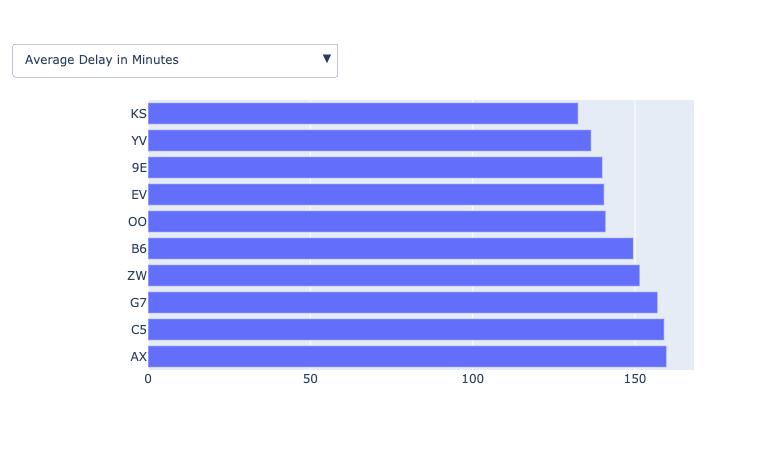

'https://plotly.com/~GailB-ca/34/'

In [230]:
fig = go.Figure()
fig.add_trace(go.Bar(
            x=delays_by_carrier['avg_delay'],
            y=delays_by_carrier['op_unique_carrier'],
            orientation='h'))
buttons=list([dict(args=[{'x':[delays_by_carrier['avg_delay']]
                         , 'y':[delays_by_carrier['op_unique_carrier']]
                         }, [0]],                   
                   label="Average Delay in Minutes",
                   method="restyle"
                ),
                dict(args=[{'x':[fuel_consump_pass_dist_by_carrier['avg_fuel_per_passenger_per_mile']]
                           , 'y': [fuel_consump_pass_dist_by_carrier['unique_carrier']]
                           }, [0]],                 
                   label="Average Gallons of Fuel per Passenger per Mile",
                   method="restyle"
                )
            ])
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=-0.25,
            xanchor="left",
            y=1.25,
            yanchor="top"
        )
    ]
)

fig.show()
py.plot(fig)